In [2]:
# -*- coding: utf-8 -*-
"""
The script demonstrates the performance of an interpolation algorithm when applied to a large dataset.
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from itertools import compress
import time
%matplotlib inline  
import sys
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/mu529/Bus-Capstone')

# these two modules are homemade
import gtfs
import arrivals
import time
import ttools
import seqtools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

### Previous versions of the interpolation function. (final version is below)

In [3]:
# for iteration over dataframe rows (each row is a collection of lists of necessary data)
def interpolate_stops3(merged_row):
    distance_stops = merged_row.shape_stop_dist
    if len(merged_row.timestamp)<2:
        return [[]]    
    list1, list2 = zip(*sorted(zip(merged_row.timestamp,merged_row.veh_dist_along_trip)))
    veh_pings = pd.Series(index=list1,data=list2)
    last = veh_pings.idxmax()
    first = veh_pings.sort_index(ascending=False).idxmin()
    veh_pings = veh_pings.dropna()
    if len(veh_pings) == 0:
        return [[]]
    inter_stops = veh_pings.loc[first:last]
    if len(inter_stops)<2:
        return [[]]
    x = inter_stops.values
    y = inter_stops.index.values
    f = interpolate.interp1d(x,y)
    xnew = distance_stops
    masker = (xnew > min(x)) & (xnew < max(x))
    xnew = list(compress(xnew,masker))
    interp_times = pd.to_timedelta(f(xnew),unit='ns')    
    return [list(compress(merged_row.shape_stop_id,masker)),interp_times]

In [4]:
# for iteration over dict-of-dicts (each dict is a collection of lists of necessary data)
def interpolate_stops4(d):
    distance_stops = d['shape_stop_dist']
    if len(d['timestamp'])<2:
        return [[]]    
    list1, list2 = zip(*sorted(zip(d['timestamp'],d['veh_dist_along_trip'])))
    veh_pings = pd.Series(index=list1,data=list2)
    last = veh_pings.idxmax()
    first = veh_pings.sort_index(ascending=False).idxmin()
    veh_pings = veh_pings.dropna()
    if len(veh_pings) == 0:
        return [[]]
    inter_stops = veh_pings.loc[first:last]
    if len(inter_stops)<2:
        return [[]]
    x = inter_stops.values
    y = inter_stops.index.values
    f = interpolate.interp1d(x,y)
    xnew = distance_stops
    masker = (xnew > min(x)) & (xnew < max(x))
    xnew = list(compress(xnew,masker))
    interp_times = pd.to_timedelta(f(xnew),unit='ns')    
    return [list(compress(d['shape_stop_id'],masker)),interp_times]

### Current working version of interpolation function.
Takes several lists as inputs, which can be stored together as a dataframe row (merged_row).

merged_row.shape_stop_dist is a list of distances of *all* stops from the schedule on that shape.<p>
mergedrow.shape_stop_id is a list of stop_id labels for those stops<p>

In [5]:
# for iteration over dataframe rows (each row is a collection of lists of necessary data)
def interpolate_stops5(merged_row,tol=100):
    distance_stops = merged_row.shape_stop_dist
    # if the returned object is not a list, it does not contain any information, so there is nothing to interpolate.
    if type(distance_stops) != list:
        return [[]]
    # if there are fewer than 2 pings, no interpolation is possible
    if len(merged_row.timestamp)<2:
        return [[]]    
    # assemble the ping data as a pandas Series, for convenient use of dropna() method
    list1, list2 = zip(*sorted(zip(merged_row.timestamp,merged_row.veh_dist_along_trip)))
    veh_pings = pd.Series(index=list1,data=list2)
    veh_pings = veh_pings.dropna()
    # pings must be cleaned for cases when the vehicle "moves backwards" along the route.
    # this may occur when the vehicle is actually finishing another trip, or returning to the first stop
    # the proposed method is to identify the the largest monotonic increasing subsequence
    first, last = seqtools.longest_inc_range(veh_pings.values,tolerance=tol)
    if len(veh_pings) == 0:
        return [[]]
    valid_pings = veh_pings.iloc[first:last]
    if len(valid_pings)<2:
        return [[]]
    # finally, perform the interpolation with the cleaned data
    x = valid_pings.values
    y = valid_pings.index.values
    f = interpolate.interp1d(x,y)
    xnew = distance_stops
    masker = (xnew > min(x)) & (xnew < max(x))
    xnew = list(compress(xnew,masker))
    # return the estimated times (as timedelta dtype) and the stop labels
    interp_times = pd.to_timedelta(f(xnew),unit='ns')
    return [list(compress(merged_row.shape_stop_id,masker)),interp_times]

## Now try it on a WHOLE DAY of data...
#### Important: input dataset needs to be cleaned first by removing any that report a "next stop" that is not valid for the shape.  (See filter_invalid_stops.ipynb)

In [6]:
# get the sample of parsed AVL data.  Beware, large files take more time.
bustime = pd.read_csv('spark_parse/1203_cleaned.csv')
bustime.drop('Unnamed: 0',axis=1,inplace=True)

#### Additional cleaning steps
Remove prefixes from trip and shape labels.  (GTFS data does not use the prefix).  Distance values need to be numeric, not string.

In [7]:
# beware!  Bonan is still working on organizing the extract files.  these columns may change.

bustime.drop_duplicates(['vehicle_id','timestamp'],inplace=True)
bustime['trip_id'] = bustime['trip_id'].str.replace('MTA NYCT_','')
bustime['trip_id'] = bustime['trip_id'].str.replace('MTABC_','')
bustime['shape_id'] = bustime['shape_id'].str.replace('MTA_','')

bustime.set_index(['route','trip_id','trip_date','vehicle_id'],inplace=True,drop=True)
bustime.set_index('timestamp',append=True,drop=False,inplace=True)

# for demonstration, use a subset. Just get data one day.
tripDateLookup = "2015-12-03"
bustime = bustime.xs((tripDateLookup),level=(2),drop_level=False)
# note that the AVL dataframe must be sorted by timestammp, since iloc[]
# selection is used later in this script to find the earliest time
bustime.sort_index(inplace=True)
bustime['timestamp'] = bustime['timestamp'].apply(ttools.parseActualTime,tdate='2015-12-03')

bustime['stop_dist_on_trip'] = bustime['stop_dist_on_trip'].convert_objects(convert_numeric=True)
bustime['dist_from_stop'] = bustime['dist_from_stop'].convert_objects(convert_numeric=True)
# add calculated column for distance along shape
bustime['veh_dist_along_trip'] = bustime['stop_dist_on_trip'] - bustime['dist_from_stop']

print 'Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.'

Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.


#### Create a separate dataframe containing the distances of ALL stops along each shape.
Although GTFS is the official source for all stop information, Bus Time has the distances calculated already according to the shape.  The problem is the records from each trip may not contain information about all the stops (for example, when some are skipped).  Using a large enough sample should resolve that problem.

In [8]:
bustime_distances = bustime.drop(['timestamp'],axis=1,inplace=False)
bustime_distances = bustime_distances.reset_index().drop(['route','trip_id','trip_date','vehicle_id','timestamp',
                                                'lat','lon','dist_from_stop','presentable_dist',
                                                'veh_dist_along_trip'],axis=1,inplace=False)

stop_distances = bustime_distances.drop_duplicates(['shape_id','next_stop_id','stop_dist_on_trip'])
stop_distances = stop_distances.query('stop_dist_on_trip > 0.1')

# stop_distances.next_stop_id = stop_distances.next_stop_id.str.replace('MTA_','')

stop_distances = stop_distances.sort(['shape_id','stop_dist_on_trip']).reset_index(drop=True)

print 'Finished creating stop-distances reference dataframe.'

Finished creating stop-distances reference dataframe.


## Organization of Bus Time data
A trip is identified as the grouping of records for each route, trip date, trip_id **and** vehicle_id.  Both are required because sometimes trip_id labels are "recycled" during the day and used by two different vehicles serving the route.

In [9]:
# make a copy
avl_data2 = bustime

In [10]:
gb = avl_data2.groupby(level=(0,1,2,3))

For each **trip data group**, take the reported shape_id (single value), which will be used next to get the information about all stops along that shape.<p>
From each group, take the necessary data in list form:
<ol>
<li>time stamps of all the pings</li>
<li>vehicle distances for thosee pings (note: Python list ordering is persistent, so the two lists can be kept separate)</li></ol>

In [11]:
shape_ids = gb['shape_id'].agg(lambda x:x.value_counts().index[0])
reported_timestamps = gb['timestamp'].apply(list)
reported_dists = gb['veh_dist_along_trip'].apply(list)

... and also take the necessary data (in list form) from each **shape**:
<ol start="3">
<li>labels of all the stops along that shape, from the separate dataframe of stop distances</li>
<li>the distances of all those stops</li><ol>
<br>Also, rename the objects for clarity.  And then merge together.

In [12]:
all_stops = stop_distances.groupby('shape_id')['next_stop_id'].apply(list)
all_dists = stop_distances.groupby('shape_id')['stop_dist_on_trip'].apply(list)
all_dists.name = 'shape_stop_dist'
all_stops.name = 'shape_stop_id'
all_stop_dists = pd.DataFrame(shape_ids).merge(pd.DataFrame(all_dists),left_on='shape_id',right_index=True).merge(pd.DataFrame(all_stops),left_on='shape_id',right_index=True)

## Two approaches for consolidated the data.
Approach 1: merge everything into a dataframe

In [13]:
starttime = time.time()
avl_merged = pd.concat([all_stop_dists,reported_timestamps,reported_dists],axis=1)
print 'Processing time:'
print time.time() - starttime

Processing time:
1.81179118156


Approach 2: Use a for-loop to merge everything as a dict-of-dicts, instead of a dataframe

In [14]:
starttime = time.time()
test_dict = {}
for i,v in all_stop_dists.iterrows():
    test_dict[i] = {'shape_stop_dist':v.shape_stop_dist,'shape_stop_id':v.shape_stop_id,
                    'timestamp':reported_timestamps.loc[i],'veh_dist_along_trip':reported_dists.loc[i]}
print 'Processing time:'
print time.time() - starttime

Processing time:
20.9029839039


### Compare performance when iterating over dataframe of lists or dict of dicts
Approach 1

In [15]:
starttime = time.time()
results = {}
for i, v in avl_merged.iterrows():
    results[i] = interpolate_stops3(v)
print 'Processing time:'
print time.time() - starttime

Processing time:
128.379277945


Approach 2 (using dict-of-dicts)

In [15]:
starttime = time.time()
results2 = {}
for k, v in test_dict.iteritems():
    results2[k] = interpolate_stops4(v)
print 'Processing time:'
print time.time() - starttime

Processing time:
81.2485888004


Approach 3, using dataframe version but trying longest-increasing subsequence to slice array

In [16]:
starttime = time.time()
results_longest = {}
for i, v in avl_merged.iterrows():
    results_longest[i] = interpolate_stops5(v)
print 'Processing time:'
print time.time() - starttime

Processing time:
106.457950115


### Expand results into a dataframe (to use for things like headway measurement)

In [138]:
import csv
with open('2015-12-03_interpolated.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['route','trip_id','trip_date','vehicle_id','stop_id','interpolated_arrival_time'])
    for k, v in results_longest.iteritems():
        for i in range(len(v[0])):
            row = k + (v[0][i],v[1][i])
            csv_out.writerow(row)

## Investigate results and check method for data groups with more than one ping

In [21]:
lens = []
trip_count = 0
for k, v in results_longest.iteritems():
    l = len(v[0])
    if l > 0:
        trip_count += 1
    lens.append(l)
def empty_inds(lst):
    k = results_longest.keys()
    return [k[i] for i, x in enumerate(lst) if x==0]
empty_keys = empty_inds(lens)
print 'Some basic stats: '
print 'Total number of estimated arrival times'
print sum(lens)
print 'Number of trips identified overall'
print len(lens)
print 'Number of trips with estimates'
print trip_count
print 'Number of trips without valid interpolation'
print len(empty_keys)
print 'Average number of estimates per trip'
print 1.0*sum(lens)/trip_count

Some basic stats: 
Total number of estimated arrival times
1769451
Number of trips identified overall
65525
Number of trips with estimates
55844
Number of trips without valid interpolation
9681
Average number of estimates per trip
31.6856063319


In [22]:
ek_index = pd.MultiIndex.from_tuples(empty_keys)
ek_info = pd.DataFrame(data=gb.size(),index=ek_index,columns=['N'])

In [23]:
ek_info['min_ts'] = gb['timestamp'].min()
ek_info['max_ts'] = gb['timestamp'].max()
ek_info['min_dist'] = gb['veh_dist_along_trip'].min()
ek_info['max_dist'] = gb['veh_dist_along_trip'].max()

In [24]:
ek_info['ts_delta'] = ek_info['max_ts'] - ek_info['min_ts']
ek_info['dist_delta'] = ek_info['max_dist'] - ek_info['min_dist']

In [25]:
ek_info.groupby('N').size()/len(ek_info)

N
1     0.648693
2     0.140688
3     0.066729
4     0.039355
5     0.024481
6     0.019936
7     0.012189
8     0.007541
9     0.006611
10    0.006508
11    0.004442
12    0.004338
13    0.001963
14    0.002479
15    0.001549
16    0.001033
17    0.000413
18    0.001033
19    0.000826
20    0.000930
21    0.000723
22    0.000620
23    0.000516
24    0.000310
25    0.000826
26    0.000103
27    0.000516
28    0.000103
29    0.000826
30    0.000413
31    0.000103
32    0.000103
33    0.000103
34    0.000310
35    0.000103
36    0.000310
37    0.000207
38    0.000413
41    0.000103
43    0.000310
47    0.000207
48    0.000103
49    0.000207
50    0.000207
52    0.000103
56    0.000207
57    0.000207
dtype: float64

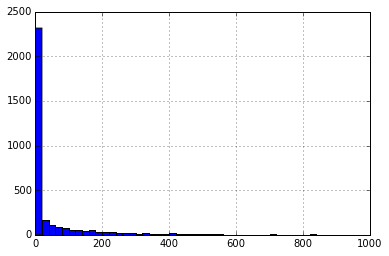

In [26]:
ek_info.query('N>1')['dist_delta'].hist(range=(0,1000),bins=50)

In [27]:
# how many of the original groupings had only 1 ping?
sum(bustime.groupby(level=(0,1,2,3)).size()==1)

6280

In [28]:
# how many with more than one ping?
sum(bustime.groupby(level=(0,1,2,3)).size()>1)

59245

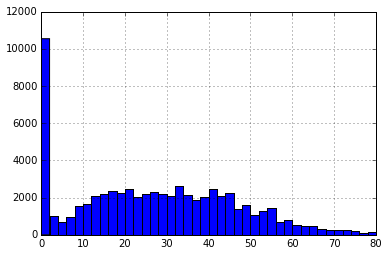

In [33]:
# how many stops were estimated for each trip data group?
pd.Series(lens).hist(range=(0,80),bins=40)

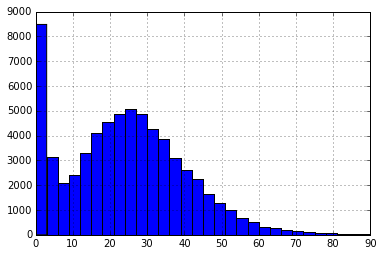

In [32]:
# how many pings were available for each trip data group?
gb.size().hist(range=(0,90),bins=30)